In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

RootDir = "/kaggle/input/sentimental-analysis-for-tweets"


filename = RootDir + "/sentiment_tweets3.csv"
df = pd.read_csv(filename)
print (df.shape)

(10314, 3)


In [17]:
df.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [18]:
df['label (depression result)'].value_counts()

0    8000
1    2314
Name: label (depression result), dtype: int64

In [19]:
selected_rows = df[df['label (depression result)'] == 0].head(2314)

In [20]:
selected_rows1= df[df['label (depression result)'] == 1].head(2314)

In [21]:
selected_rows1.head()

,Index,message to examine,label (depression result)
8000,800000,The lack of this understanding is a small but ...,1
8001,800001,i just told my parents about my depression and...,1
8002,800002,depression is something i don't speak about ev...,1
8003,800003,Made myself a tortilla filled with pb&j. My de...,1
8004,800004,@WorldofOutlaws I am gonna need depression med...,1


In [22]:
combined_df = pd.concat([selected_rows1,selected_rows], ignore_index=True)

In [23]:
combined_df.head()

,Index,message to examine,label (depression result)
0,800000,The lack of this understanding is a small but ...,1
1,800001,i just told my parents about my depression and...,1
2,800002,depression is something i don't speak about ev...,1
3,800003,Made myself a tortilla filled with pb&j. My de...,1
4,800004,@WorldofOutlaws I am gonna need depression med...,1


In [24]:
combined_df['label (depression result)'].value_counts()

0    2314
1    2314
Name: label (depression result), dtype: int64

In [26]:
tweets = combined_df.values[:,1]
labels = combined_df.values[:,2].astype(float)

Next, we load BERT:

In [27]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
bert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

We can now run the BERT model on all tweets to get their encoding

In [28]:
embeddings = bert_model.encode(tweets, show_progress_bar=True)
print (embeddings.shape)

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

(4628, 768)


The embeddings will be our features to train a classifier, but first we need tp split the data into training and test sets:

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, 
                                          test_size=0.2, random_state=42)
print ("Training set shapes:", X_train.shape, y_train.shape)
print ("Test set shapes:", X_test.shape, y_test.shape)

Training set shapes: (3702, 768) (3702,)
Test set shapes: (926, 768) (926,)


There are 768 features in the embedding vector for every tweet. Now build a simple classification model to work on them

In [30]:
from tensorflow.keras import Sequential, layers

classifier = Sequential()
classifier.add (layers.Dense(256, activation='relu', input_shape=(768,)))
classifier.add (layers.Dense(1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  
    
hist = classifier.fit (X_train, y_train, epochs=10, batch_size=16, 
                      validation_data=(X_test, y_test))

Epoch 1/10
232/232 [==============================] - 1s 3ms/step - loss: 0.1775 - accuracy: 0.9275 - val_loss: 0.0757 - val_accuracy: 0.9752
Epoch 2/10
232/232 [==============================] - 1s 3ms/step - loss: 0.0565 - accuracy: 0.9794 - val_loss: 0.0515 - val_accuracy: 0.9838
Epoch 3/10
232/232 [==============================] - 1s 3ms/step - loss: 0.0257 - accuracy: 0.9919 - val_loss: 0.0682 - val_accuracy: 0.9806
Epoch 4/10
232/232 [==============================] - 1s 3ms/step - loss: 0.0277 - accuracy: 0.9913 - val_loss: 0.0639 - val_accuracy: 0.9806
Epoch 5/10
232/232 [==============================] - 1s 3ms/step - loss: 0.0238 - accuracy: 0.9912 - val_loss: 0.0611 - val_accuracy: 0.9806
Epoch 6/10
232/232 [==============================] - 1s 3ms/step - loss: 0.0078 - accuracy: 0.9982 - val_loss: 0.0677 - val_accuracy: 0.9816
Epoch 7/10
232/232 [==============================] - 1s 3ms/step - loss: 0.0096 - accuracy: 0.9962 - val_loss: 0.0722 - val_accuracy: 0.9827
Epoch 

Plot the loss and accuracy:

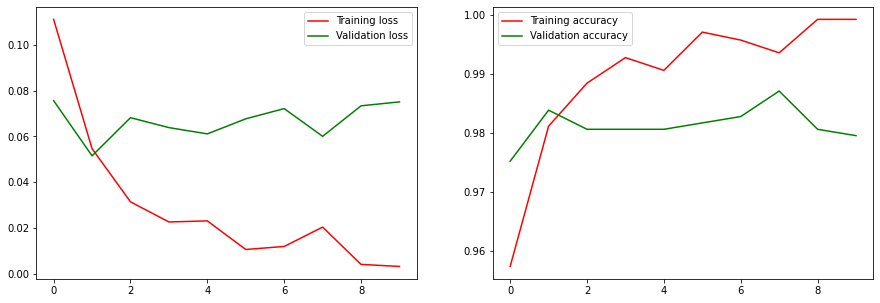

In [31]:
from matplotlib import pyplot

pyplot.figure(figsize=(15,5))
pyplot.subplot(1, 2, 1)
pyplot.plot(hist.history['loss'], 'r', label='Training loss')
pyplot.plot(hist.history['val_loss'], 'g', label='Validation loss')
pyplot.legend()
pyplot.subplot(1, 2, 2)
pyplot.plot(hist.history['accuracy'], 'r', label='Training accuracy')
pyplot.plot(hist.history['val_accuracy'], 'g', label='Validation accuracy')
pyplot.legend()
pyplot.show()

It seems we reach a very good prediction accuracy (>98%) immediately, with almost no improvement by additional epochs